# Burnout en empleados corporativos
## Análisis de datos - TP 2

Este conjunto de datos fue creado como parte de un estudio de investigación destinado a comprender los factores que contribuyen al agotamiento laboral (*burnout*) de los empleados en entornos corporativos. Los datos fueron recolectados mediante encuestas estructuradas y estudios observacionales realizados en empresas con sede en Bengaluru, India. Se enfoca en una variedad de indicadores relacionados con el bienestar laboral y personal, tales como el equilibrio entre la vida laboral y personal, el apoyo del gerente, los patrones de sueño, la carga de trabajo y el reconocimiento. El conjunto de datos ofrece una visión integral de variables comúnmente asociadas con el estrés y el agotamiento de los empleados, brindando información valiosa para el análisis organizacional y el diseño de estrategias de intervención. *(14-04-2018)*

**Fuente del dataset:**  
Shankar, Kunal, 2018, *"Employee Burnout Analysis"*, Harvard Dataverse, [https://doi.org/10.7910/DVN/VG6KQD](https://doi.org/10.7910/DVN/VG6KQD)  

---
## Carga del dataset y split (train / validation / test)
---

Para el TP1 se había exportado el dataset con el preprocesamiento realizado. Sin embargo, observamos que se habían aplicado las transformaciones al dataset completo, en lugar de realizar el fit con el dataset de entrenamiento y luego aplicarlas a validación y test. Por esta razón, se volvió a cargar el dataset y se dividió al inicio en train-validation-test, para aplicar correctamente las transformaciones propuestas en el TP1.

### 1.1. Importación de librerías

In [190]:
import pandas as pd
import matplotlib.pyplot as plt

### 1.2. Cargar datos desde un archivo CSV a un df de Pandas

In [191]:
# Cargar el dataset original 'enriched_employee_dataset.csv'
df_csv = pd.read_csv("data/enriched_employee_dataset.csv")

In [192]:
# Vista rápida del dataset
df_csv.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Years in Company,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2,3.0,3.8,0.16,16,35,7.5,3,3,1,16,2
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1,2.0,5.0,0.36,16,41,7.1,5,3,3,10,5
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2,NaN,5.8,0.49,16,53,5.7,2,3,5,17,0
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1,1.0,2.6,0.20,16,43,6.7,3,3,1,13,2
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3,7.0,6.9,0.52,16,51,5.2,1,3,4,18,0


---
## Limpieza de datos
---

**Más de un nulo:** 

Se eliminan las observaciones que tengan más de un valor nulo, ya que no representan un alto porcentaje del total y podrían ser datos erróneos o haber distintas razones por las que la persona eligió no responder.

In [193]:
# Ver cuántas filas tienen al menos dos nulos
print("Filas con al menos dos nulos:", df_csv.isna().sum(axis=1).gt(1).sum())

Filas con al menos dos nulos: 447


In [194]:
# Eliminar filas con dos nulos
df_limpio = df_csv.dropna(thresh=len(df_csv.columns)-1)
print("Filas restantes tras eliminación:", df_limpio.shape[0])

Filas restantes tras eliminación: 22303


In [195]:
# Registros restantes en el dataset luego de la limpieza de registros nulos
print("% registros restantes en el dataset:", round((df_limpio.shape[0] / df_csv.shape[0])*100,2),"%")

% registros restantes en el dataset: 98.04 %


**Burn Rate:** 

Al tratarse de la variable de salida, sería incorrecto imputarle algún valor, ya que esto tendría una gran repercusión en los resultados del modelo y podríamos estar introduciendo ruido. Por esta razón, se eliminan las filas con valores nulos en Burn Rate.

In [196]:
# Eliminar filas con valor nulo en Burn Rate
df_limpio = df_limpio.dropna(subset=['Burn Rate'])
print("Filas restantes tras eliminación:", df_limpio.shape[0])

Filas restantes tras eliminación: 21439


In [197]:
# Comparar antes y después
print("Valores nulos antes de limpieza:\n", df_csv[['Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']].isnull().sum())
print("Valores nulos después de limpieza:\n", df_limpio[['Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']].isnull().sum())

Valores nulos antes de limpieza:
 Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64
Valores nulos después de limpieza:
 Resource Allocation     1091
Mental Fatigue Score    1758
Burn Rate                  0
dtype: int64


In [198]:
# Registros restantes en el dataset luego de la limpieza de registros nulos
print("% registros restantes en el dataset:", round((df_limpio.shape[0] / df_csv.shape[0])*100,2),"%")

% registros restantes en el dataset: 94.24 %


---
## Dividir el dataset (train / validation / test)
---

### 2.1. Hacer el split del dataset (train / validation / test)

In [199]:
from sklearn.model_selection import train_test_split

# Split inicial: 70% train, 15% validation, 15% test
df_train, df_temp = train_test_split(df_limpio, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

# Confirmar tamaños
print(f"Train: {df_train.shape}, Validation: {df_val.shape}, Test: {df_test.shape}")

Train: (15007, 17), Validation: (3216, 17), Test: (3216, 17)


In [200]:
# Crear tabla resumen
split_summary = pd.DataFrame({
    'Conjunto': ['Train', 'Validation', 'Test'],
    'Cantidad de registros': [len(df_train), len(df_val), len(df_test)]
})

# Calcular el total y el porcentaje
total = len(df_limpio)
split_summary['Porcentaje (%)'] = split_summary['Cantidad de registros'] / total * 100

# Mostrar como tabla
split_summary

,Conjunto,Cantidad de registros,Porcentaje (%)
0,Train,15007,69.998601
1,Validation,3216,15.000700
2,Test,3216,15.000700


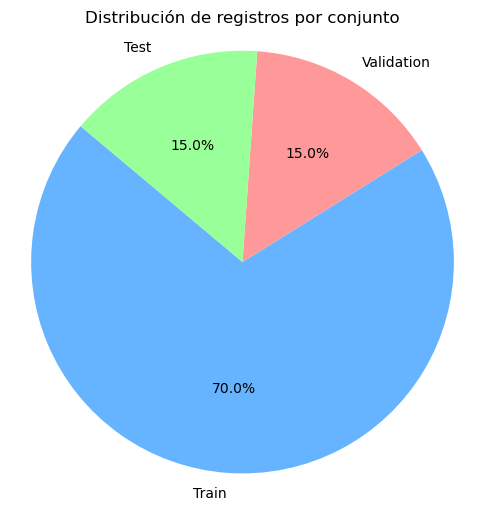

In [201]:
plt.figure(figsize=(6,6))
plt.pie(split_summary['Cantidad de registros'], labels=split_summary['Conjunto'], 
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999','#99ff99'], startangle=140)
plt.title('Distribución de registros por conjunto')
plt.axis('equal')
plt.show()

---
## Limpieza de datos
---

### 3.1. Tratamiento de valores nulos en dataset de entrenamiento

In [202]:
# Revisar datos faltantes y duplicados
print(f"Valores faltantes: {df_train.isnull().sum()}")  # Calcular valores faltantes

Valores faltantes: Employee ID                   0
Date of Joining               0
Gender                        0
Company Type                  0
WFH Setup Available           0
Designation                   0
Resource Allocation         775
Mental Fatigue Score       1222
Burn Rate                     0
Years in Company              0
Work Hours per Week           0
Sleep Hours                   0
Work-Life Balance Score       0
Manager Support Score         0
Deadline Pressure Score       0
Team Size                     0
Recognition Frequency         0
dtype: int64


<Axes: >

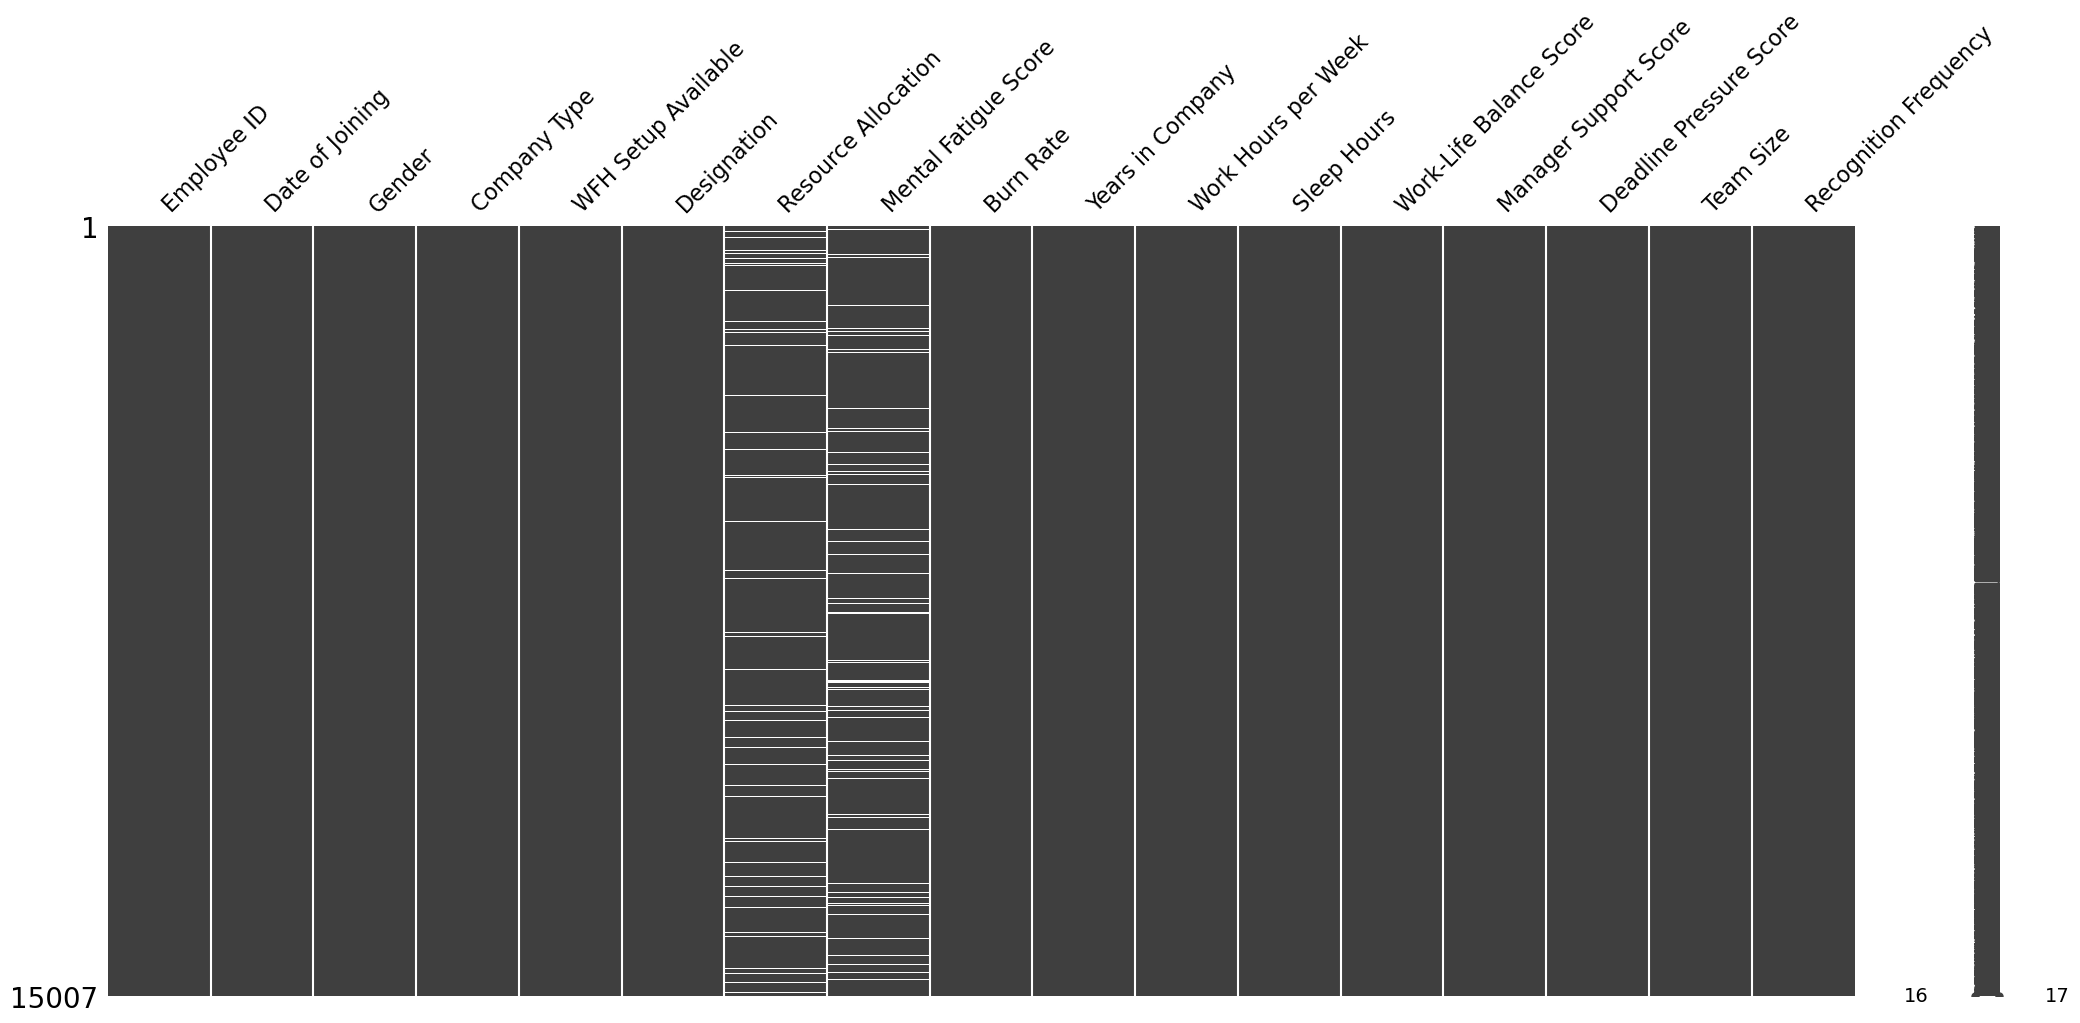

In [203]:
# Visualización de valores faltantes
import missingno as msno
msno.matrix(df_train)

### 3.2. Imputación de 'Mental Fatigue Score' con Regresión Lineal

Se decide imputar los valores faltantes de la variable **'Mental Fatigue Score'** utilizando un modelo de **regresión lineal** basado en las variables con mayor correlación.
Se decide utilizar únicamente las variables con **alta correlación positiva** según lo evaluado en el TP1 para la imputación de valores faltantes.

In [204]:
from sklearn.linear_model import LinearRegression

# 1. Preparación del dataset con datos completos para entrenamiento y evaluación para el 'Modelo Simple'

df_mf_train = df_train[
    df_train['Mental Fatigue Score'].notnull() &
    df_train['Designation'].notnull() &
    df_train['Resource Allocation'].notnull() &
    df_train['Burn Rate'].notnull() &
    df_train['Work Hours per Week'].notnull() &
    df_train['Deadline Pressure Score'].notnull()
]

# Definir variables independientes y dependiente
X_mf = df_mf_train[['Designation', 'Resource Allocation', 'Burn Rate', 'Work Hours per Week', 'Deadline Pressure Score']]
y_mf = df_mf_train['Mental Fatigue Score']


# 2. Entrenar el modelo y evaluar la capacidad predictiva

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

# Dividir en train y test para evaluar
X_train, X_test, y_train, y_test = train_test_split(
    X_mf, y_mf, test_size=0.2, random_state=42
)

# Crear y entrenar el modelo
model_mf = LinearRegression()
model_mf.fit(X_train, y_train)

# Predicción en set de test
y_pred = model_mf.predict(X_test)

# 3. Imputación de los valores faltantes de 'Mental Fatigue Score' usando el modelo entrenado para el dataset de entrenamiento

# Filtrar registros con Mental Fatigue Score nulo pero con las otras variables presentes
df_mf_pred = df_train[
    df_train['Mental Fatigue Score'].isnull() &
    df_train['Designation'].notnull() &
    df_train['Resource Allocation'].notnull() &
    df_train['Burn Rate'].notnull() &
    df_train['Work Hours per Week'].notnull() &
    df_train['Deadline Pressure Score'].notnull()
]

X_mf_pred = df_mf_pred[['Designation', 'Resource Allocation', 'Burn Rate', 'Work Hours per Week', 'Deadline Pressure Score']]

# Aplicar la imputación a train
df_train.loc[df_mf_pred.index, 'Mental Fatigue Score'] = model_mf.predict(X_mf_pred)

In [205]:
# 4. Imputación de los valores faltantes de 'Mental Fatigue Score' usando el modelo entrenado para los datasets de validación y test

# Dataset de validación
# Filtrar registros con 'Mental Fatigue Score' nulo pero con las otras variables presentes
df_mf_pred = df_val[
    df_val['Mental Fatigue Score'].isnull() &
    df_val['Designation'].notnull() &
    df_val['Resource Allocation'].notnull() &
    df_val['Burn Rate'].notnull() &
    df_val['Work Hours per Week'].notnull() &
    df_val['Deadline Pressure Score'].notnull()
]

X_mf_pred = df_mf_pred[['Designation', 'Resource Allocation', 'Burn Rate', 'Work Hours per Week', 'Deadline Pressure Score']]

# Aplicar la imputación a train
df_val.loc[df_mf_pred.index, 'Mental Fatigue Score'] = model_mf.predict(X_mf_pred)

# Dataset de test
# Filtrar registros con 'Mental Fatigue Score' nulo pero con las otras variables presentes
df_mf_pred = df_test[
    df_test['Mental Fatigue Score'].isnull() &
    df_test['Designation'].notnull() &
    df_test['Resource Allocation'].notnull() &
    df_test['Burn Rate'].notnull() &
    df_test['Work Hours per Week'].notnull() &
    df_test['Deadline Pressure Score'].notnull()
]

X_mf_pred = df_mf_pred[['Designation', 'Resource Allocation', 'Burn Rate', 'Work Hours per Week', 'Deadline Pressure Score']]

# Aplicar la imputación a train
df_test.loc[df_mf_pred.index, 'Mental Fatigue Score'] = model_mf.predict(X_mf_pred)

### 3.3. Imputación de 'Resource Allocation' con Regresión Lineal

Se decide imputar los valores faltantes de la variable **'Resource Allocation'** utilizando un modelo de **regresión lineal** basado en las variables con mayor correlación.

In [206]:
# 1. Preparación del dataset con datos completos para entrenamiento y evaluación para el 'Modelo Simple'
# Dataset para entrenamiento y evaluación (sin nulos en variables predictoras y target)

df_ra_train = df_train[
    df_train['Resource Allocation'].notnull() &
    df_train['Designation'].notnull() &
    df_train['Burn Rate'].notnull() &
    df_train['Mental Fatigue Score'].notnull() &
    df_train['Work Hours per Week'].notnull() &
    df_train['Deadline Pressure Score'].notnull()
]

# Variables predictoras - Modelo simple
X_ra = df_ra_train[['Designation', 'Burn Rate', 'Mental Fatigue Score',
                     'Work Hours per Week', 'Deadline Pressure Score']]
y_ra = df_ra_train['Resource Allocation']

# 2. Entrenar el modelo y evaluar la capacidad predictiva
# División en train/test
X_train_ra, X_test_ra, y_train_ra, y_test_ra = train_test_split(
    X_ra, y_ra, test_size=0.2, random_state=42
)

# Modelo
model_ra = LinearRegression()
model_ra.fit(X_train_ra, y_train_ra)

# Predicción
y_pred_ra = model_ra.predict(X_test_ra)

# 3. Imputación de los valores faltantes de 'Resource Allocation' usando el modelo entrenado

# Filas completas para entrenamiento
df_ra_train = df_train[df_train['Resource Allocation'].notnull() &
                 df_train['Designation'].notnull() &
                 df_train['Mental Fatigue Score'].notnull() &
                 df_train['Burn Rate'].notnull() &
                 df_train['Work Hours per Week'].notnull()]

X_ra = df_ra_train[['Designation', 'Mental Fatigue Score', 'Burn Rate',
                    'Work Hours per Week']]
y_ra = df_ra_train['Resource Allocation']

model_ra = LinearRegression()
model_ra.fit(X_ra, y_ra)

# Predecir valores nulos
df_ra_pred = df_train[df_train['Resource Allocation'].isnull() &
                df_train['Designation'].notnull() &
                df_train['Mental Fatigue Score'].notnull() &
                df_train['Burn Rate'].notnull() &
                df_train['Work Hours per Week'].notnull()]

X_ra_pred = df_ra_pred[['Designation', 'Mental Fatigue Score', 'Burn Rate',
                        'Work Hours per Week']]

# Aplicar la imputación
df_train.loc[df_ra_pred.index, 'Resource Allocation'] = model_ra.predict(X_ra_pred)

In [207]:
# 4. Imputación de los valores faltantes de 'Resource Allocation' usando el modelo entrenado para los datasets de validación y test

# Dataset de validación
# Filtrar registros con 'Resource Allocation' nulo pero con las otras variables presentes
df_ra_pred = df_val[df_val['Resource Allocation'].isnull() &
                df_val['Designation'].notnull() &
                df_val['Mental Fatigue Score'].notnull() &
                df_val['Burn Rate'].notnull() &
                df_val['Work Hours per Week'].notnull()]

X_ra_pred = df_ra_pred[['Designation', 'Mental Fatigue Score', 'Burn Rate',
                        'Work Hours per Week']]

# Aplicar la imputación
df_val.loc[df_ra_pred.index, 'Resource Allocation'] = model_ra.predict(X_ra_pred)

# Dataset de test
# Filtrar registros con 'Resource Allocation' nulo pero con las otras variables presentes
df_ra_pred = df_test[df_test['Resource Allocation'].isnull() &
                df_test['Designation'].notnull() &
                df_test['Mental Fatigue Score'].notnull() &
                df_test['Burn Rate'].notnull() &
                df_test['Work Hours per Week'].notnull()]

X_ra_pred = df_ra_pred[['Designation', 'Mental Fatigue Score', 'Burn Rate',
                        'Work Hours per Week']]

# Aplicar la imputación
df_test.loc[df_ra_pred.index, 'Resource Allocation'] = model_ra.predict(X_ra_pred)

### 3.4. Verificación de registros restantes en el dataset

In [208]:
# Revisar datos faltantes
print(f"Valores faltantes: {df_train.isnull().sum()}")  # Calcular valores faltantes en train
print(f"Valores faltantes: {df_val.isnull().sum()}")  # Calcular valores faltantes en val
print(f"Valores faltantes: {df_test.isnull().sum()}")  # Calcular valores faltantes en test

Valores faltantes: Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation        0
Mental Fatigue Score       0
Burn Rate                  0
Years in Company           0
Work Hours per Week        0
Sleep Hours                0
Work-Life Balance Score    0
Manager Support Score      0
Deadline Pressure Score    0
Team Size                  0
Recognition Frequency      0
dtype: int64
Valores faltantes: Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation        0
Mental Fatigue Score       0
Burn Rate                  0
Years in Company           0
Work Hours per Week        0
Sleep Hours                0
Work-Life Balance Score    0
Manager Support Score      0
Deadline Pressure Score    0
Team Size            

### 3.5. Tratamiento de valores duplicados

In [209]:
print("Cantidad de datos duplicados en train:", df_train.duplicated().sum())
print("Cantidad de datos duplicados en val:", df_val.duplicated().sum())
print("Cantidad de datos duplicados en test:", df_test.duplicated().sum())

Cantidad de datos duplicados en train: 0
Cantidad de datos duplicados en val: 0
Cantidad de datos duplicados en test: 0


### 2.6. Ajuste del tipo de datos adecuado para el análisis

In [210]:
print(f"Columnas del dataframe:\n{df_train.dtypes}\n")

Columnas del dataframe:
Employee ID                 object
Date of Joining             object
Gender                      object
Company Type                object
WFH Setup Available         object
Designation                  int64
Resource Allocation        float64
Mental Fatigue Score       float64
Burn Rate                  float64
Years in Company             int64
Work Hours per Week          int64
Sleep Hours                float64
Work-Life Balance Score      int64
Manager Support Score        int64
Deadline Pressure Score      int64
Team Size                    int64
Recognition Frequency        int64
dtype: object



In [211]:
# Convertir columna de 'Resource Allocation' a tipo integer
df_train['Resource Allocation'] = df_train['Resource Allocation'].astype(int)
df_val['Resource Allocation'] = df_val['Resource Allocation'].astype(int)
df_test['Resource Allocation'] = df_test['Resource Allocation'].astype(int)

# Se convierten las columnas categóricas a tipo 'category'
df_train['Gender']=df_train['Gender'].astype('category')
df_train['Company Type']=df_train['Company Type'].astype('category')
df_train['WFH Setup Available']=df_train['WFH Setup Available'].astype('category')
df_train.head()

df_val['Gender']=df_val['Gender'].astype('category')
df_val['Company Type']=df_val['Company Type'].astype('category')
df_val['WFH Setup Available']=df_val['WFH Setup Available'].astype('category')
df_val.head()

df_test['Gender']=df_test['Gender'].astype('category')
df_test['Company Type']=df_test['Company Type'].astype('category')
df_test['WFH Setup Available']=df_test['WFH Setup Available'].astype('category')
df_test.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Years in Company,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency
13723,fffe31003500370033003100,2008-11-09,Female,Service,No,3,5,5.500000,0.45,16,50,5.9,2,3,5,14,1
1569,fffe3800310036003500,2008-12-20,Male,Product,No,3,7,6.499455,0.54,16,48,5.4,2,3,5,10,0
7147,fffe32003900310032003600,2008-04-09,Female,Product,No,3,6,8.400000,0.87,16,51,5.4,1,1,4,9,1
8776,fffe3600330034003300,2008-11-04,Female,Service,Yes,1,1,0.100000,0.03,16,44,7.7,3,3,1,11,2
3114,fffe3100330036003300,2008-07-29,Male,Product,No,3,5,5.800000,0.55,16,51,6.1,1,3,5,18,0


In [212]:
print(f"Columnas del dataframe de train:\n{df_train.dtypes}\n")
print(f"Columnas del dataframe de val:\n{df_val.dtypes}\n")
print(f"Columnas del dataframe de test:\n{df_test.dtypes}\n")

Columnas del dataframe de train:
Employee ID                  object
Date of Joining              object
Gender                     category
Company Type               category
WFH Setup Available        category
Designation                   int64
Resource Allocation           int64
Mental Fatigue Score        float64
Burn Rate                   float64
Years in Company              int64
Work Hours per Week           int64
Sleep Hours                 float64
Work-Life Balance Score       int64
Manager Support Score         int64
Deadline Pressure Score       int64
Team Size                     int64
Recognition Frequency         int64
dtype: object

Columnas del dataframe de val:
Employee ID                  object
Date of Joining              object
Gender                     category
Company Type               category
WFH Setup Available        category
Designation                   int64
Resource Allocation           int64
Mental Fatigue Score        float64
Burn Rate            

---
## Preselección y creación de features
---

#### Drop de features 
Quitamos los features que no van a aportar valor al análisis debido a que:
- 'Employee ID': es un ID.
- 'Date of Joining' & 'Years in Company': todos los empleados ingresaron en el año 2008.

In [213]:
# Se quitan las columnas Employee ID, Date of Joining, Year
df_train = df_train.drop(columns=['Employee ID', 'Date of Joining','Years in Company'])
df_val = df_val.drop(columns=['Employee ID', 'Date of Joining','Years in Company'])
df_test = df_test.drop(columns=['Employee ID', 'Date of Joining','Years in Company'])
df_train.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency
13259,Male,Product,Yes,4,9,8.8,0.71,59,5.1,2,3,5,7,1
8709,Female,Service,No,1,2,6.1,0.37,43,7.1,5,3,3,18,4
21179,Male,Service,Yes,3,5,3.7,0.30,39,7.6,5,5,3,15,5
15282,Male,Product,No,2,5,6.7,0.51,55,5.9,1,3,5,7,0
11606,Female,Service,Yes,1,2,6.5,0.45,58,5.8,1,3,5,18,1


#### Creación de nuevos features 
Creamos un nuevo feature: **Work-Sleep Ratio**

Objetivo: incorporar una nueva variable que relacione las horas trabajadas con las horas de descanso para capturar posibles desequilibrios en la rutina diaria de los empleados.

Definición:
> `Work-Sleep Ratio = (Work Hours per Week / 5) / Sleep Hours`

Este nuevo indicador representa la cantidad de horas trabajadas por día (asumiendo una jornada laboral de 5 días a la semana) en relación con las horas de sueño. Valores más altos pueden indicar un mayor desequilibrio entre trabajo y descanso, lo que podría tener impacto en el nivel de burnout o fatiga mental de los empleados.

Justificación:
- El balance entre trabajo y descanso es un factor crítico en la salud laboral.
- Esta métrica permite integrar dos variables relevantes en un solo indicador.
- Puede servir como input útil en la clasificación del riesgo de burnout o en análisis posteriores.

In [214]:
# Se crea una nueva columna 'Work-Sleep Ratio' que representa la proporción de horas de trabajo a horas de sueño
df_train['Work-Sleep Ratio'] = (df_train['Work Hours per Week'] / 5) / df_train['Sleep Hours']
df_val['Work-Sleep Ratio'] = (df_val['Work Hours per Week'] / 5) / df_val['Sleep Hours']
df_test['Work-Sleep Ratio'] = (df_test['Work Hours per Week'] / 5) / df_test['Sleep Hours']
df_train.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency,Work-Sleep Ratio
13259,Male,Product,Yes,4,9,8.8,0.71,59,5.1,2,3,5,7,1,2.313725
8709,Female,Service,No,1,2,6.1,0.37,43,7.1,5,3,3,18,4,1.211268
21179,Male,Service,Yes,3,5,3.7,0.30,39,7.6,5,5,3,15,5,1.026316
15282,Male,Product,No,2,5,6.7,0.51,55,5.9,1,3,5,7,0,1.864407
11606,Female,Service,Yes,1,2,6.5,0.45,58,5.8,1,3,5,18,1,2.000000


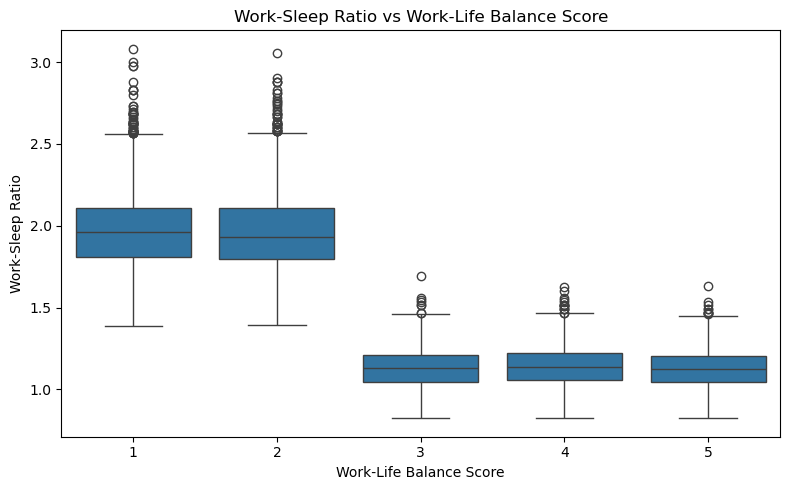

Coeficiente de correlación de Spearman: -0.7503
Valor p: 0.0000
Existe una relación estadísticamente significativa entre Work-Sleep Ratio y Work-Life Balance Score.


In [215]:
# Análisis de la relación entre el 'Work-Sleep Ratio' y el 'Work-Life Balance Score'
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 1. Gráfico de caja para ver la distribución del ratio según el score de balance
plt.figure(figsize=(8, 5))
sns.boxplot(x='Work-Life Balance Score', y='Work-Sleep Ratio', data=df_train)
plt.title('Work-Sleep Ratio vs Work-Life Balance Score')
plt.xlabel('Work-Life Balance Score')
plt.ylabel('Work-Sleep Ratio')
plt.tight_layout()
plt.show()

# 2. Correlación de Spearman (no paramétrica, adecuada si las variables no son normales)
corr, p_value = spearmanr(df_train['Work-Sleep Ratio'], df_train['Work-Life Balance Score'])

print(f"Coeficiente de correlación de Spearman: {corr:.4f}")
print(f"Valor p: {p_value:.4f}")

if p_value < 0.05:
    print("Existe una relación estadísticamente significativa entre Work-Sleep Ratio y Work-Life Balance Score.")
else:
    print("No se encontró una relación estadísticamente significativa.")

#### Relación entre Work-Sleep Ratio y Work-Life Balance Score

Se exploró la relación entre el indicador creado `Work-Sleep Ratio` y la variable original `Work-Life Balance Score`.

- Se utilizó un **boxplot** para visualizar cómo varía el Work-Sleep Ratio en función del puntaje de Work-Life Balance.
- Además, se aplicó un **test de correlación de Spearman**, dado que ambas variables no siguen una distribución normal.

**Resultados**:
- **Coeficiente de correlación de Spearman**: -0.7503
- **Valor p**: < 0.0001

Esto indica una **relación negativa fuerte y estadísticamente significativa**: a mayor balance entre vida y trabajo, más cercano a uno ratio trabajo/sueño diario.

**Outliers y complementariedad**:
A pesar de esta fuerte relación, el boxplot muestra una presencia significativa de outliers en todos los grupos, lo que sugiere que hay variabilidad individual importante.

Por esta razón, **no se considera apropiado eliminar ninguna de las dos variables**, consideramos que:
- `Work-Life Balance Score` representa la percepción subjetiva del empleado.
- `Work-Sleep Ratio` es un indicador objetivo calculado a partir del tiempo reportado.

Ambas aportan valor desde perspectivas distintas y se conservarán para análisis y modelos posteriores.

In [216]:
df_train.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency,Work-Sleep Ratio
count,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000
mean,2.178117,4.451922,5.717290,0.451038,47.739921,6.112461,2.528620,2.820617,3.464650,11.063037,1.740454,1.622106
std,1.135463,2.040165,1.922403,0.198490,7.612035,0.886285,1.386697,1.273404,1.394545,4.912281,1.700249,0.446830
min,0.000000,0.000000,0.000000,0.000000,35.000000,3.400000,1.000000,1.000000,1.000000,3.000000,0.000000,0.823529
25%,1.000000,3.000000,4.500000,0.310000,41.000000,5.400000,1.000000,2.000000,2.000000,7.000000,0.000000,1.166667
50%,2.000000,4.000000,5.885332,0.450000,49.000000,6.000000,2.000000,3.000000,4.000000,11.000000,1.000000,1.728814
75%,3.000000,6.000000,7.100000,0.590000,54.000000,6.900000,4.000000,4.000000,5.000000,15.000000,3.000000,2.000000
max,5.000000,10.000000,10.790322,1.000000,59.000000,8.800000,5.000000,5.000000,5.000000,19.000000,5.000000,3.081081


---
## Codificación (encoding)
---

#### One-Hot encoding
Crea una columna binaria (0/1) para cada categoría.

In [217]:
from sklearn.preprocessing import OneHotEncoder

# Variables categóricas a codificar
categorical_cols = ['Gender', 'Company Type', 'WFH Setup Available']

# Crear el codificador
onehot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Ajustar solo con df_train
onehot_encoder.fit(df_train[categorical_cols])

# Transformar datasets
encoded_train = onehot_encoder.transform(df_train[categorical_cols]).astype(int)
encoded_val = onehot_encoder.transform(df_val[categorical_cols]).astype(int)
encoded_test = onehot_encoder.transform(df_test[categorical_cols]).astype(int)

# Convertir a DataFrame
columns = onehot_encoder.get_feature_names_out(categorical_cols)
encoded_train_df = pd.DataFrame(encoded_train, columns=columns, index=df_train.index)
encoded_val_df = pd.DataFrame(encoded_val, columns=columns, index=df_val.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=columns, index=df_test.index)

# Unir y eliminar originales
df_train = df_train.drop(columns=categorical_cols).join(encoded_train_df)
df_val = df_val.drop(columns=categorical_cols).join(encoded_val_df)
df_test = df_test.drop(columns=categorical_cols).join(encoded_test_df)
df_train.head(10)

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency,Work-Sleep Ratio,Gender_Male,Company Type_Service,WFH Setup Available_Yes
13259,4,9,8.8,0.71,59,5.1,2,3,5,7,1,2.313725,1,0,1
8709,1,2,6.1,0.37,43,7.1,5,3,3,18,4,1.211268,0,1,0
21179,3,5,3.7,0.30,39,7.6,5,5,3,15,5,1.026316,1,1,1
15282,2,5,6.7,0.51,55,5.9,1,3,5,7,0,1.864407,1,0,0
11606,1,2,6.5,0.45,58,5.8,1,3,5,18,1,2.000000,0,1,1
12386,2,6,6.8,0.53,52,5.7,2,3,5,4,1,1.824561,1,1,1
55,3,5,6.1,0.39,37,7.7,3,4,3,3,3,0.961039,0,0,1
5559,2,3,5.6,0.43,48,4.3,1,3,5,16,1,2.232558,0,0,0
12254,3,8,8.1,0.71,55,4.6,1,1,4,5,1,2.391304,0,1,0
21081,1,2,6.8,0.49,48,5.3,2,3,5,14,0,1.811321,0,0,1


---
## Normalización y estandarización
---

Para aplicar la estandarización, no se tienen en cuenta las features a las que se aplicó el one-hot encoding, ya que su valor es 0/1. Tampoco se aplica a 'Burn Rate', debido a que sus valores ya están entre 0 y 1.

In [218]:
# Estandarización de los datos de train
# Seleccion de columnas a escalar
cols_to_scale = ['Designation', 'Resource Allocation',
    'Mental Fatigue Score', 'Work Hours per Week', 'Sleep Hours',
    'Work-Life Balance Score', 'Manager Support Score',
    'Deadline Pressure Score', 'Team Size', 'Recognition Frequency','Work-Sleep Ratio'
]

from sklearn.preprocessing import StandardScaler

# Escalado de las columnas seleccionadas usando StandardScaler
scaler = StandardScaler()
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_train.head(10)

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency,Work-Sleep Ratio,Gender_Male,Company Type_Service,WFH Setup Available_Yes
13259,1.604582,2.229344,1.603624,0.71,1.479296,-1.142403,-0.381221,0.140874,1.101005,-0.827146,-0.435512,1.547887,1,0,1
8709,-1.037599,-1.201866,0.199086,0.37,-0.622709,1.114283,1.782266,0.140874,-0.333202,1.412214,1.328994,-0.919481,0,1,0
21179,0.723855,0.268653,-1.049393,0.30,-1.148210,1.678454,1.782266,1.711519,-0.333202,0.801480,1.917162,-1.333415,1,1,1
15282,-0.156872,0.268653,0.511205,0.51,0.953795,-0.239729,-1.102383,0.140874,1.101005,-0.827146,-1.023681,0.542284,1,0,0
11606,-1.037599,-1.201866,0.407166,0.45,1.347921,-0.352563,-1.102383,0.140874,1.101005,1.412214,-0.435512,0.845750,0,1,1
12386,-0.156872,0.758826,0.563225,0.53,0.559669,-0.465397,-0.381221,0.140874,1.101005,-1.437880,-0.435512,0.453108,1,1,1
55,0.723855,0.268653,0.199086,0.39,-1.410960,1.791288,0.339941,0.926196,-0.333202,-1.641459,0.740825,-1.479508,0,0,1
5559,-0.156872,-0.711693,-0.061014,0.43,0.034168,-2.045077,-1.102383,0.140874,1.101005,1.005058,-0.435512,1.366229,0,0,0
12254,0.723855,1.739171,1.239485,0.71,0.953795,-1.706574,-1.102383,-1.429772,0.383902,-1.234302,-0.435512,1.721513,0,1,0
21081,-1.037599,-1.201866,0.563225,0.49,0.034168,-0.916734,-0.381221,0.140874,1.101005,0.597902,-1.023681,0.423474,0,0,1


In [219]:
# Estandarización de los datos de validación
df_val[cols_to_scale] = scaler.transform(df_val[cols_to_scale])
df_val.head(10)

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency,Work-Sleep Ratio,Gender_Male,Company Type_Service,WFH Setup Available_Yes
22584,-0.156872,-0.221520,-0.061014,0.41,0.691044,0.098774,-0.381221,0.140874,1.101005,-0.419989,-0.435512,0.195990,1,1,1
19760,-0.156872,-1.201866,-1.465553,0.22,-1.410960,1.452786,1.061104,0.140874,-1.767410,-0.419989,1.917162,-1.392311,0,1,1
7036,-1.037599,-0.221520,0.511205,0.45,0.953795,-1.142403,-0.381221,0.140874,0.383902,-1.437880,-1.023681,1.196819,1,1,1
4268,-0.156872,0.268653,0.355146,0.44,1.479296,-0.803900,-0.381221,-0.644449,1.101005,-1.437880,-0.435512,1.260206,0,0,1
16687,0.723855,1.248998,1.811704,0.89,0.822420,-0.916734,-1.102383,-0.644449,0.383902,-0.827146,-1.023681,0.930205,0,0,0
22120,1.604582,2.229344,1.187465,0.73,0.691044,-1.932243,-1.102383,-0.644449,0.383902,-0.216411,-1.023681,1.761321,0,1,1
19682,0.723855,0.268653,0.303126,0.43,0.428294,-0.803900,-0.381221,-1.429772,0.383902,-1.437880,-1.023681,0.597077,1,1,1
19963,1.604582,1.739171,1.343525,0.73,0.953795,-0.916734,-0.381221,0.140874,1.101005,0.801480,-1.023681,1.014660,0,0,1
18691,-1.037599,-1.201866,-0.737273,0.20,-1.673711,1.565620,1.782266,0.140874,-1.050306,-0.216411,0.152657,-1.541515,0,0,1
434,-1.918326,-1.692039,-0.997373,0.17,-0.885459,0.775780,1.061104,1.711519,-1.050306,1.412214,1.328994,-0.931534,1,1,1


In [220]:
# Estandarización de los datos de test
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])
df_test.head(10)

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency,Work-Sleep Ratio,Gender_Male,Company Type_Service,WFH Setup Available_Yes
13723,0.723855,0.268653,-0.113034,0.45,0.296918,-0.239729,-0.381221,0.140874,1.101005,0.597902,-0.435512,0.162952,0,1,0
1569,0.723855,1.248998,0.406882,0.54,0.034168,-0.803900,-0.381221,0.140874,1.101005,-0.216411,-1.023681,0.348403,1,0,0
7147,0.723855,0.758826,1.395545,0.87,0.428294,-0.803900,-1.102383,-1.429772,0.383902,-0.419989,-0.435512,0.597077,0,0,0
8776,-1.037599,-1.692039,-2.922111,0.03,-0.491333,1.791288,0.339941,0.140874,-1.767410,-0.012833,0.152657,-1.072588,0,1,1
3114,0.723855,0.268653,0.043026,0.55,0.428294,-0.014060,-1.102383,0.140874,1.101005,1.412214,-1.023681,0.111960,1,0,0
13169,-0.156872,0.268653,0.459186,0.64,0.428294,-0.014060,-1.102383,-1.429772,1.101005,-0.012833,-1.023681,0.111960,0,0,1
20861,0.723855,1.248998,0.303126,0.56,0.953795,-0.916734,-1.102383,-1.429772,1.101005,-0.827146,-0.435512,1.014660,1,0,0
17885,-0.156872,-0.221520,-1.101413,0.30,-1.673711,0.662946,0.339941,1.711519,-1.767410,0.190745,1.917162,-1.292099,0,1,1
5984,-0.156872,0.268653,0.251106,0.45,1.085170,-1.142403,-1.102383,-0.644449,1.101005,-1.641459,-0.435512,1.284586,0,0,0
3838,1.604582,1.248998,1.187465,0.69,0.953795,0.437277,-0.381221,0.140874,0.383902,0.801480,-0.435512,0.157116,1,1,0


---
## Análisis y selección de features
---

#### 1. Correlación de Pearson

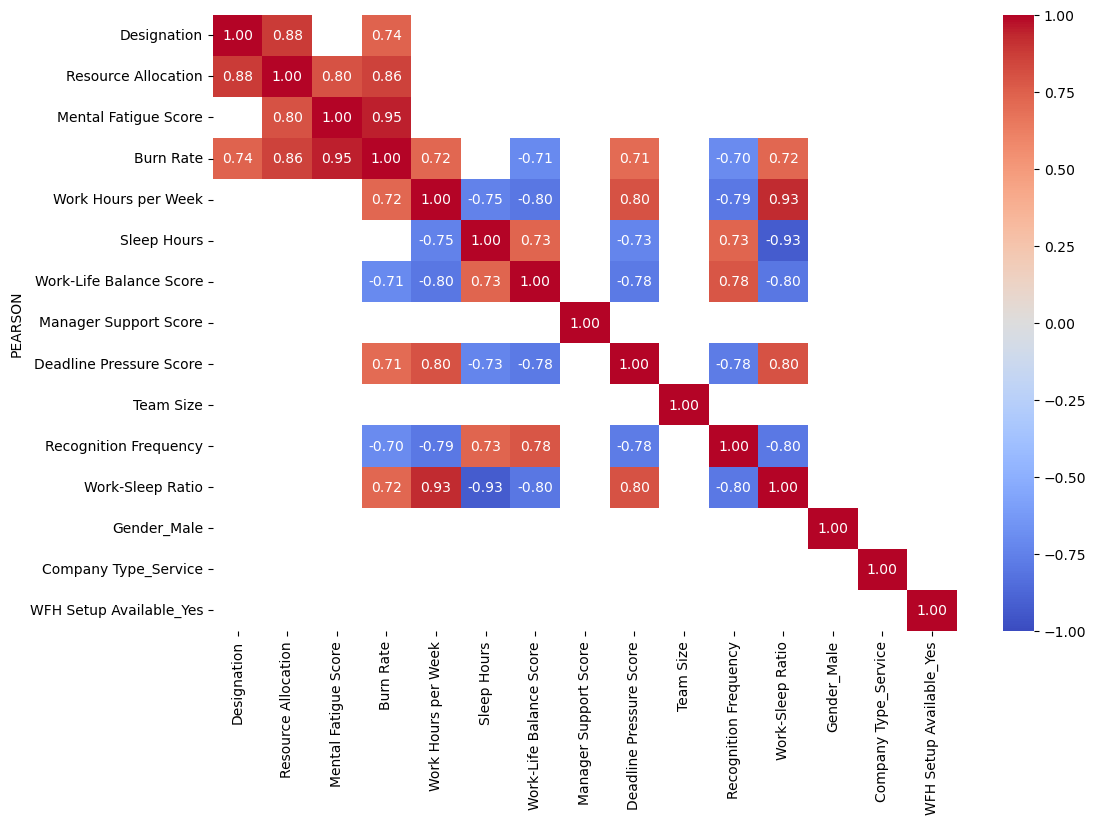

In [221]:
# Análisis de correlación de PEARSON entre variables del dataset de train
umbral = 0.7
mask_for_heatmap = (df_train.corr(method='pearson').abs() < umbral)
plt.figure(figsize=(12,8))
sns.heatmap(
    df_train.corr(method='pearson'), 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    center=0, 
    vmin=-1, 
    vmax=1,
    mask=mask_for_heatmap)
plt.ylabel('PEARSON')
plt.show()

#### 2. Correlación de Kendall

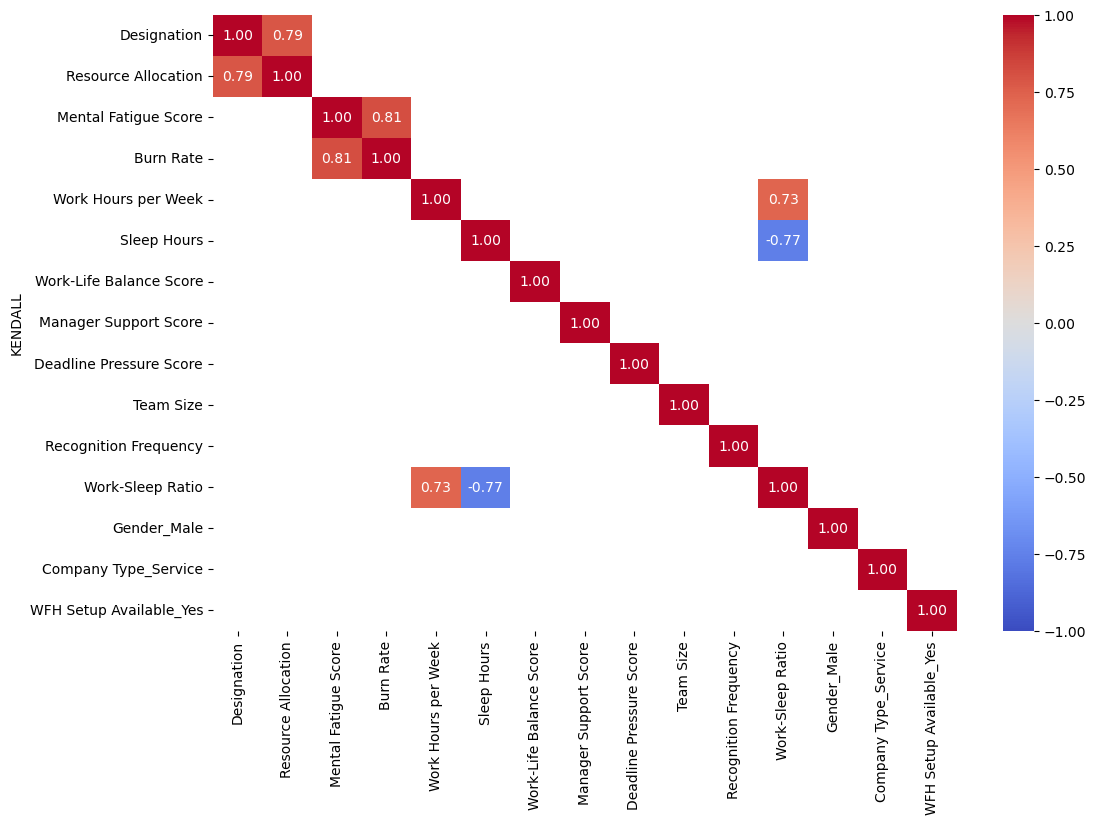

In [222]:
# Análisis de correlación de KENDALL entre variables del dataset de train
umbral = 0.7
mask_for_heatmap = (df_train.corr(method='kendall').abs() < umbral)
plt.figure(figsize=(12,8))
sns.heatmap(
    df_train.corr(method='kendall'), 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    center=0, 
    vmin=-1, 
    vmax=1,
    mask=mask_for_heatmap)
plt.ylabel('KENDALL')
plt.show()

#### Análisis de las correlaciones realizadas

Se calculó la matriz de correlación de Pearson entre las variables numéricas y binarias codificadas. Con este análisis se busca identificar relaciones lineales entre variables y evaluar posibles redundancias.

**Variables más fuertemente correlacionadas con `Burn Rate`:**

- `Mental Fatigue Score`: **0.95** → Correlación directa muy fuerte.
- `Resource Allocation`: **0.86**
- `Designation`: **0.74**
- `Work Hours per Week`: **0.72**
- `Work-Sleep Ratio` (feature creado): **0.72**
- `Deadline Pressure Score`: **0.71**
- `Work-Life Balance Score`: **-0.71**
- `Recognition Frequency`: **-0.70**


**Aporte del análisis de correlación de Kendall**

Además de la correlación de Pearson, se utilizó el coeficiente de Kendall para evaluar relaciones **monótonas no necesariamente lineales** entre las variables del dataset, especialmente con la variable target `Burn Rate`.

**Hallazgos clave:**
- La variable que mostro la más alta correlación con `Burn Rate` bajo Pearson, también lo hacen con Kendall, aunque con valores más conservadores:
  - `Mental Fatigue Score`: **0.81**

- Se observa una alta correlación entre `Resource Allocation`y `Designation`: **0.79**

- La alta correlación entre `Work-Sleep Ratio` y las variables `Sleep Hours` (-0.77) y `Work Hours per Week` (0.73) son esperadas ya que la primera se calcula en función de las otras dos.

#### Selección en base a la matriz de correlación

Dado que se observa que algunas de estas variables que tienen una alta correlación con `Burn Rate` además presentan una correlación significativa entre sí, para reducir la multicolinealidad y conservar representatividad de distintas dimensiones, se decide seleccionar las siguientes variables:

- `Mental Fatigue Score`: tiene la correlación directa más fuerte con la variable target.
- `Resource Allocation`: se elimina porque tiene una alta correlación con `Mental Fatigue Score`.
- `Designation`: tiene una significativa correlación con la variable target.
- `Work Hours per Week`: también tiene una significativa correlación con la variable target.
- `Work-Sleep Ratio`: se elimina porque tiene una alta correlación con `Work Hours per Week`.
- `Deadline Pressure Score`: se elimina porque tiene una alta correlación con `Work Hours per Week`.
- `Work-Life Balance Score`: se elimina porque tiene una alta correlación negativa con `Work Hours per Week`.
- `Recognition Frequency`: se elimina porque tiene una alta correlación negativa con `Work Hours per Week`.

En conclusión, seleccionamos las siguientes variables:

- `Mental Fatigue Score`
- `Designation`
- `Work Hours per Week`

In [223]:
X_train_correlation_best = df_train[['Mental Fatigue Score', 'Designation', 'Work Hours per Week']]

#### 3. Información mutua

In [224]:
y_train = df_train['Burn Rate']
X_train = df_train.drop(columns=['Burn Rate'])

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_regression

# Información mutua (solo aplicado a train para el análisis de características)
selector_mi = SelectKBest(score_func=mutual_info_regression, k=3)
X_train_best = selector_mi.fit_transform(X_train, y_train)
selected_indices = selector_mi.get_support()
selected_features = X_train.columns[selected_indices]
scores = selector_mi.scores_[selected_indices]
print("\nCaracterísticas seleccionadas (Inf. mutua):")
for feature, score in zip(selected_features, scores):
    print(f"{feature}: {score:.4f}")


Características seleccionadas (Inf. mutua):
Resource Allocation: 0.7067
Mental Fatigue Score: 1.5201
Work Hours per Week: 0.6928


#### Selección final de variables: criterio combinado

Se aplicó una estrategia mixta para la selección de variables predictoras:

- **Primero**, se realizó una **preselección basada en la matriz de correlación con la variable target (`Burn Rate`)**, priorizando aquellas con relación fuerte y directa, y eliminando las que estaban fuertemente correlacionadas entre sí para evitar multicolinealidad.
- **Luego**, se utilizó el método de **Información Mutua (mutual_info_regression)** para validar la capacidad de cada variable para aportar información sobre la variable objetivo.

**Preselección y decisión final**

Las variables candidatas se analizaron de la siguiente forma:

| Variable                   | ¿Alta correlación con otra?           | ¿Seleccionada? | Justificación |
|----------------------------|----------------------------------------|----------------|---------------|
| Mental Fatigue Score       | No                                     | Sí          | Máxima correlación directa con `Burn Rate` y mayor puntaje de información mutua (1.5179). |
| Resource Allocation        | Alta con Mental Fatigue              | Sí          | Alta correlación directa con `Burn Rate` y alto puntaje de información mutua (0.7209). |
| Designation                | Alta con Resource Allocation        | No          | Buena correlación con `Burn Rate`, pero consideramos que son excluyentes con `Resource Allocation` dada su alta correlación mutua. |
| Work Hours per Week        | No                                     | Sí          | Alta correlación directa con `Burn Rate` y alto puntaje en información mutua (0.6874) |
| Work-Sleep Ratio           | Alta con Work Hours / Sleep Hours   | No          | Eliminada por redundancia. |
| Deadline Pressure Score    | Alta con Work Hours per Week        | No          | Redundante, eliminada. |
| Work-Life Balance Score    | Alta inversa con Work Hours         | No          | Redundante, eliminada. |
| Recognition Frequency      | Alta inversa con Work Hours         | No          | Redundante, eliminada. |

**Variables seleccionadas:**
- `Mental Fatigue Score`
- `Resource Allocation`
- `Work Hours per Week`


In [225]:
# Separar los datos de validación y test
y_val = df_val['Burn Rate']
X_val = df_val.drop(columns=['Burn Rate'])

y_test = df_test['Burn Rate']
X_test = df_test.drop(columns=['Burn Rate'])

In [226]:
# Aplicar el filtro a val y test
X_val_best = selector_mi.transform(X_val)
X_test_best = selector_mi.transform(X_test)

---
## Extracción de features 
---

#### 1. PCA - dataset con todas las features

En primer lugar, se aplica la técnica de PCA sobre el dataset completo, sin tener en cuenta la preselección de features.

In [227]:
from sklearn.decomposition import PCA

# Aplicar PCA
pca_all = PCA(n_components=4)
components_all = pca_all.fit_transform(X_train) # Hacer PCA sobre el dataset sin filtrar

# Resultado como DataFrame para graficar o analizar
df_components_all = pd.DataFrame(components_all, columns=['PC1', 'PC2','PC3', 'PC4'], index=y_train.index)
df_components_all['Burn Rate'] = y_train.values

print(pca_all.explained_variance_ratio_)  # % de varianza capturada por cada componente

[0.61104964 0.09287224 0.08519791 0.03596343]


In [228]:
df_components_all.head()

,PC1,PC2,PC3,PC4,Burn Rate
13259,3.557220,1.392724,-1.000493,1.207845,0.71
8709,-2.599877,0.092652,1.404216,-0.648386,0.37
21179,-3.271896,2.177124,0.532743,0.348602,0.30
15282,1.843674,-0.679793,-0.748141,0.348133,0.51
11606,1.147494,-1.906860,1.654736,0.475229,0.45


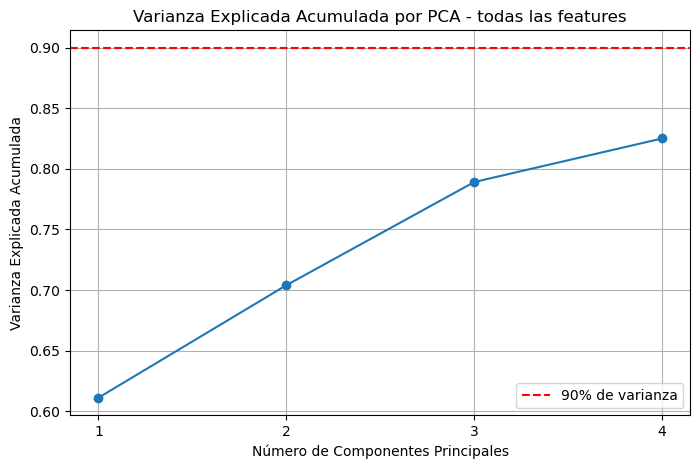

In [229]:
# Varianza explicada por componente
explained_variance = pca_all.explained_variance_ratio_

# varianza acumulada
cumulative_var = np.cumsum(explained_variance)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por PCA - todas las features')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.xticks([1, 2, 3,4])
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Conclusión del gráfico de Varianza Explicada Acumulada

- El análisis PCA muestra que con **4 componentes** se explica aproximadamente el **83%** de la varianza total del dataset.
- Se observa que no se alcanza el umbral fijado del 90%, por lo que se decide evaluar otras alternativas para obtener resultados más representativos, con menor pérdida de información.

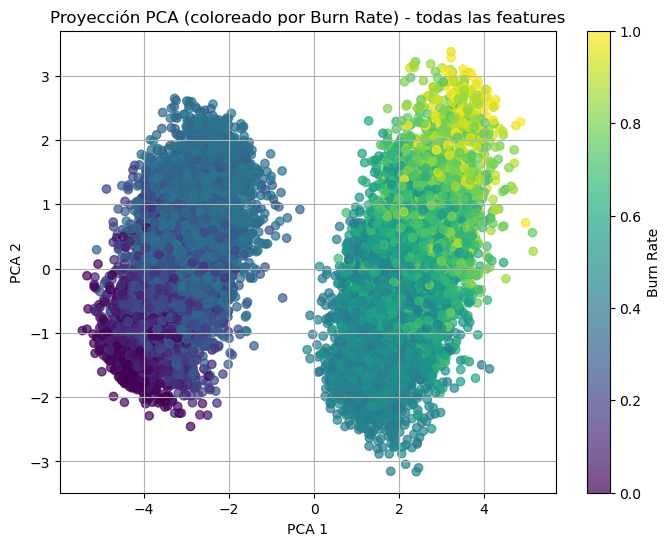

In [230]:
# Proyección de los datos en el espacio PCA
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_components_all['PC1'], df_components_all['PC2'], c=y_train, cmap='viridis', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Proyección PCA (coloreado por Burn Rate) - todas las features')
plt.colorbar(scatter, label='Burn Rate')
plt.grid()
plt.show()

#### Conclusiones de la proyección PCA

A pesar de no alcanzar el umbral fijado del 90% se observa que:

- La proyección de los datos en las dos primeras componentes principales permite visualizar patrones importantes de variabilidad en el dataset original.
- Al colorear los puntos por el valor de **`Burn Rate`**, se observa una clara **transición de colores** (de morado a amarillo) que indica un gradiente en los niveles de agotamiento laboral.
- Esto sugiere que las variables originales que componen **PCA 1 y PCA 2** contienen información relevante y **capturan gran parte de la estructura asociada al burnout**.
- Se identifican **dos regiones diferenciadas** en el plano PCA, lo cual podría reflejar perfiles de empleados con bajo y alto nivel de burnout.
- Esta visualización **respalda el uso de técnicas de reducción de dimensionalidad** tanto para exploración como para mejorar interpretabilidad de modelos.
- PCA1 es el componente que mejor discrimina entre observaciones con bajo y alto Burn Rate, ya que el eje x muestra una clara separación horizontal entre dos grandes grupos.

#### 2. PCA - dataset con las features preseleccionadas por correlación

En segundo término, se aplica la técnica de PCA sobre el dataset con las features que se preseleccionaron en base a la matriz de correlación.

In [231]:
# Aplicar PCA
pca_corr = PCA(n_components=2)
components_corr = pca_corr.fit_transform(X_train_correlation_best) # Hacer PCA sobre el dataset filtrado según matriz de correlación

# Resultado como DataFrame para graficar o analizar
df_components_corr = pd.DataFrame(components_corr, columns=['PC1', 'PC2'], index=y_train.index)
df_components_corr['Burn Rate'] = y_train.values  # or .reset_index(drop=True) if needed

print(pca_corr.explained_variance_ratio_)  # % de varianza capturada por cada componente

[0.75700722 0.16053096]


In [232]:
df_components_corr.head()

,PC1,PC2,Burn Rate
13259,2.706285,-0.083751,0.71
8709,-0.809460,0.279418,0.37
21179,-0.875823,-1.315440,0.30
15282,0.757195,0.785493,0.51
11606,0.419732,1.684503,0.45


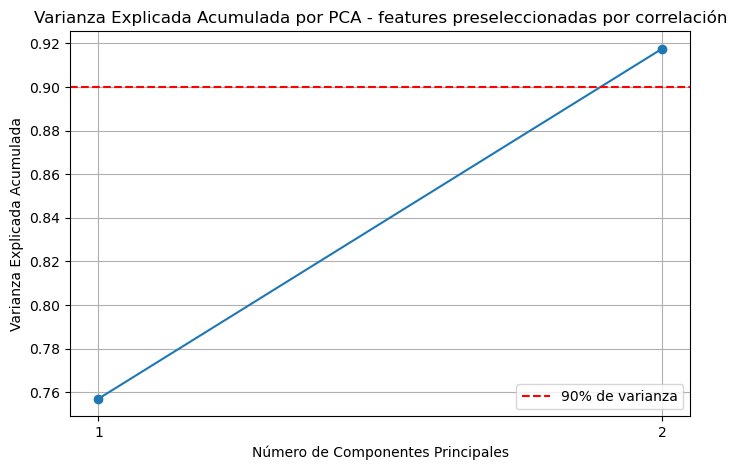

In [233]:
# Varianza explicada por componente
explained_variance = pca_corr.explained_variance_ratio_

# varianza acumulada
cumulative_var = np.cumsum(explained_variance)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por PCA - features preseleccionadas por correlación')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.xticks([1, 2])
plt.legend(loc='lower right')
plt.grid()
plt.show()

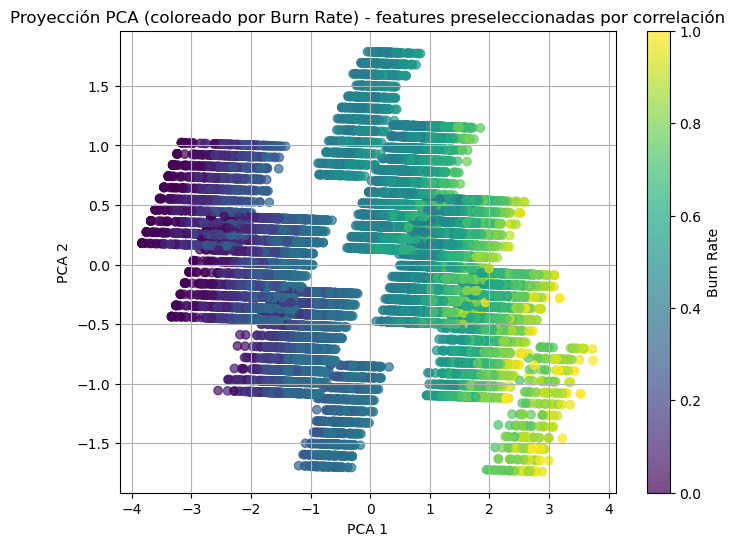

In [234]:
# Proyección de los datos en el espacio PCA
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_components_corr['PC1'], df_components_corr['PC2'], c=y_train, cmap='viridis', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Proyección PCA (coloreado por Burn Rate) - features preseleccionadas por correlación')
plt.colorbar(scatter, label='Burn Rate')
plt.grid()
plt.show()

#### Conclusión del análisis gráfico para preselección de features por la matriz de correlación

- El análisis PCA muestra que con **2 componentes** se explica aproximadamente el **92%** de la varianza total del dataset.
- Se observa que **se supera el umbral fijado del 90%** solo con 2 componentes, por lo que esto muestra una notable mejora con respecto al análisis previo.
- El último gráfico de proyección PCA, indica una más clara separación entre los valores de `Burn Rate`.
- Estos resultados validan el método de selección de features según la matriz de correlación.
- Para profundizar el análisis, se decide realizar la comparación con el método de selección por información mutua.

#### 3. PCA - dataset con las features seleccionadas por información mutua

Finalmente, se aplica la técnica de PCA sobre el dataset con las features que se seleccionaron por información mutua.

In [235]:
# Aplicar PCA
pca_mi = PCA(n_components=2)
components_mi = pca_mi.fit_transform(X_train_best) # Hacer PCA sobre el dataset filtrado por inf. mutua

# Resultado como DataFrame para graficar o analizar
df_components_mi = pd.DataFrame(components_mi, columns=['PC1', 'PC2'], index=y_train.index)
df_components_mi['Burn Rate'] = y_train.values

print(pca_mi.explained_variance_ratio_)  # % de varianza capturada por cada componente

[0.79999439 0.13887545]


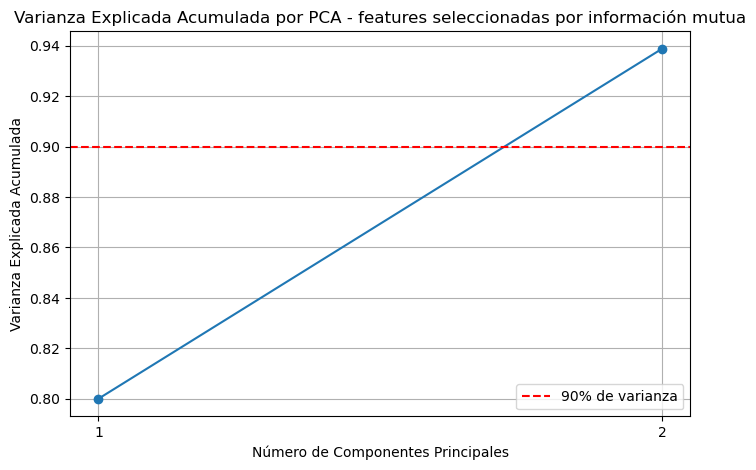

In [236]:
# Varianza explicada por componente
explained_variance = pca_mi.explained_variance_ratio_

# varianza acumulada
cumulative_var = np.cumsum(explained_variance)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por PCA - features seleccionadas por información mutua')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.xticks([1, 2])
plt.legend(loc='lower right')
plt.grid()
plt.show()

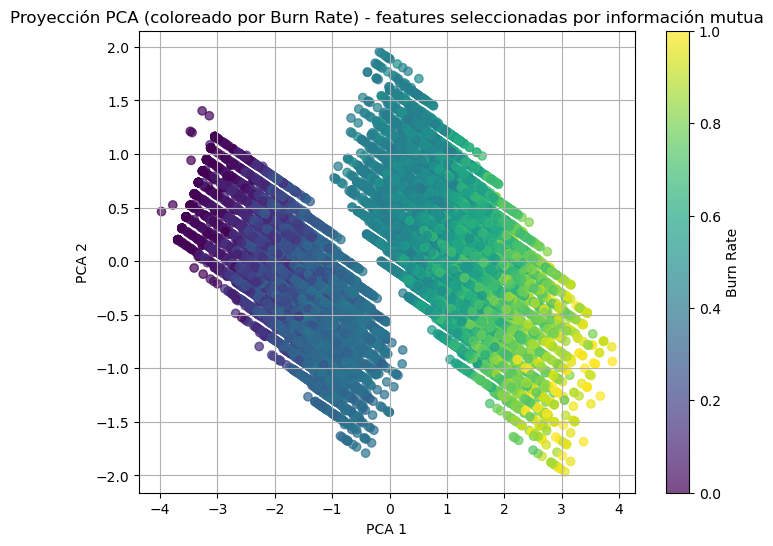

In [237]:
# Proyección de los datos en el espacio PCA
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_components_mi['PC1'], df_components_mi['PC2'], c=y_train, cmap='viridis', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Proyección PCA (coloreado por Burn Rate) - features seleccionadas por información mutua')
plt.colorbar(scatter, label='Burn Rate')
plt.grid()
plt.show()

#### Conclusión del análisis gráfico para selección de features por información mutua

- El análisis PCA muestra que con **2 componentes** ahora se explica aproximadamente el **94%** de la varianza total del dataset.
- Se observa que nuevamente **se supera el umbral fijado del 90%** solo con 2 componentes, y se obtienen resultados aún mejores con respecto al análisis previo.
- En el último gráfico de proyección PCA, no hay puntos “desordenados” en el color, sino un gradiente suave, lo que sugiere que la estructura del burnout es capturable con estos componentes.
- En base a estos resultados se elige el método de selección de features por información mutua + PCA como el más adecuado para el posterior entrenamiento de un modelo.

#### Conclusiones finales del análisis PCA

Es importante tener en cuenta que la varianza explicada por PCA no es comparable entre el primer análisis y los otros dos, ya que su valor depende de la cantidad de features sobre las que se aplica. La elección de cuál de las opciones usar (dataset completo, PCA de 4 componentes o PCA de 2 componentes) estará asociada al modelo a aplicar, dependiendo de si funciona mejor con un dataset más compacto o si puede manejar el dataset completo. Para este trabajo, y en base a los resutados y al gráfico obtenido, consideramos que la preselección de variables con información mutua + PCA resulta una opción adecuada para el entrenamiento de un modelo, aunque la decisión final dependerá de la evaluación del modelo y las métricas obtenidas.

#### Aplicación de PCA a los datasets de validación y test

In [238]:
# Transformar los conjuntos de validación y test usando PCA
components_val_mi = pca_mi.transform(X_val_best)
components_test_mi = pca_mi.transform(X_test_best)

In [239]:
# Resultado como DataFrame para graficar o analizar sobre validación
df_components_val_mi = pd.DataFrame(components_val_mi, columns=['PC1', 'PC2'], index=y_val.index)
df_components_val_mi['Burn Rate'] = y_val.values
df_components_val_mi.head()

,PC1,PC2,Burn Rate
22584,0.212101,0.695062,0.41
19760,-2.353229,-0.180713,0.22
7036,0.700617,0.783355,0.45
4268,1.178711,0.981853,0.44
16687,2.267638,-0.399728,0.89


In [240]:
# Resultado como DataFrame para graficar o analizar sobre test
df_components_test_mi = pd.DataFrame(components_test_mi, columns=['PC1', 'PC2'], index=y_test.index)
df_components_test_mi['Burn Rate'] = y_test.values
df_components_test_mi.head()

,PC1,PC2,Burn Rate
13723,0.250321,0.122077,0.45
1569,0.990058,-0.733057,0.54
7147,1.516423,-0.365671,0.87
8776,-3.013590,1.151212,0.03
3114,0.416188,0.194770,0.55


---
## Análisis de balance/desbalance de clases
---

Si bien este es un problema de regresión sobre la variable `Burn Rate`, se realiza el análisis a continuación en el caso de querer convertirlo a un problema de clasificación.

Para esto se agrupan los valores d ela variable `Burn Rate` en tres clases según el riesgo de burnout del empleado:
- **Bajo**: menos de 0.3
- **Medio**: de 0.3 a 0.6
- **Alto**: de 0.6 a 1

In [241]:
# Análisis de balance/desbalance de clases
bins = [0, 0.3, 0.6, 1.0]
labels = ['Bajo', 'Medio', 'Alto']

# Clasificación del riesgo de burnout en el dataset de entrenamiento
df_train['Burnout Risk'] = pd.cut(
    df_train['Burn Rate'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
df_train.head(10)

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency,Work-Sleep Ratio,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Burnout Risk
13259,1.604582,2.229344,1.603624,0.71,1.479296,-1.142403,-0.381221,0.140874,1.101005,-0.827146,-0.435512,1.547887,1,0,1,Alto
8709,-1.037599,-1.201866,0.199086,0.37,-0.622709,1.114283,1.782266,0.140874,-0.333202,1.412214,1.328994,-0.919481,0,1,0,Medio
21179,0.723855,0.268653,-1.049393,0.30,-1.148210,1.678454,1.782266,1.711519,-0.333202,0.801480,1.917162,-1.333415,1,1,1,Bajo
15282,-0.156872,0.268653,0.511205,0.51,0.953795,-0.239729,-1.102383,0.140874,1.101005,-0.827146,-1.023681,0.542284,1,0,0,Medio
11606,-1.037599,-1.201866,0.407166,0.45,1.347921,-0.352563,-1.102383,0.140874,1.101005,1.412214,-0.435512,0.845750,0,1,1,Medio
12386,-0.156872,0.758826,0.563225,0.53,0.559669,-0.465397,-0.381221,0.140874,1.101005,-1.437880,-0.435512,0.453108,1,1,1,Medio
55,0.723855,0.268653,0.199086,0.39,-1.410960,1.791288,0.339941,0.926196,-0.333202,-1.641459,0.740825,-1.479508,0,0,1,Medio
5559,-0.156872,-0.711693,-0.061014,0.43,0.034168,-2.045077,-1.102383,0.140874,1.101005,1.005058,-0.435512,1.366229,0,0,0,Medio
12254,0.723855,1.739171,1.239485,0.71,0.953795,-1.706574,-1.102383,-1.429772,0.383902,-1.234302,-0.435512,1.721513,0,1,0,Alto
21081,-1.037599,-1.201866,0.563225,0.49,0.034168,-0.916734,-0.381221,0.140874,1.101005,0.597902,-1.023681,0.423474,0,0,1,Medio


In [242]:
# Clasificación del riesgo de burnout en el dataset de validación
df_val['Burnout Risk'] = pd.cut(
    df_val['Burn Rate'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
df_val.head(10)

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency,Work-Sleep Ratio,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Burnout Risk
22584,-0.156872,-0.221520,-0.061014,0.41,0.691044,0.098774,-0.381221,0.140874,1.101005,-0.419989,-0.435512,0.195990,1,1,1,Medio
19760,-0.156872,-1.201866,-1.465553,0.22,-1.410960,1.452786,1.061104,0.140874,-1.767410,-0.419989,1.917162,-1.392311,0,1,1,Bajo
7036,-1.037599,-0.221520,0.511205,0.45,0.953795,-1.142403,-0.381221,0.140874,0.383902,-1.437880,-1.023681,1.196819,1,1,1,Medio
4268,-0.156872,0.268653,0.355146,0.44,1.479296,-0.803900,-0.381221,-0.644449,1.101005,-1.437880,-0.435512,1.260206,0,0,1,Medio
16687,0.723855,1.248998,1.811704,0.89,0.822420,-0.916734,-1.102383,-0.644449,0.383902,-0.827146,-1.023681,0.930205,0,0,0,Alto
22120,1.604582,2.229344,1.187465,0.73,0.691044,-1.932243,-1.102383,-0.644449,0.383902,-0.216411,-1.023681,1.761321,0,1,1,Alto
19682,0.723855,0.268653,0.303126,0.43,0.428294,-0.803900,-0.381221,-1.429772,0.383902,-1.437880,-1.023681,0.597077,1,1,1,Medio
19963,1.604582,1.739171,1.343525,0.73,0.953795,-0.916734,-0.381221,0.140874,1.101005,0.801480,-1.023681,1.014660,0,0,1,Alto
18691,-1.037599,-1.201866,-0.737273,0.20,-1.673711,1.565620,1.782266,0.140874,-1.050306,-0.216411,0.152657,-1.541515,0,0,1,Bajo
434,-1.918326,-1.692039,-0.997373,0.17,-0.885459,0.775780,1.061104,1.711519,-1.050306,1.412214,1.328994,-0.931534,1,1,1,Bajo


In [243]:
# Clasificación del riesgo de burnout en el dataset de test
df_test['Burnout Risk'] = pd.cut(
    df_test['Burn Rate'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
df_test.head(10)

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Work Hours per Week,Sleep Hours,Work-Life Balance Score,Manager Support Score,Deadline Pressure Score,Team Size,Recognition Frequency,Work-Sleep Ratio,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Burnout Risk
13723,0.723855,0.268653,-0.113034,0.45,0.296918,-0.239729,-0.381221,0.140874,1.101005,0.597902,-0.435512,0.162952,0,1,0,Medio
1569,0.723855,1.248998,0.406882,0.54,0.034168,-0.803900,-0.381221,0.140874,1.101005,-0.216411,-1.023681,0.348403,1,0,0,Medio
7147,0.723855,0.758826,1.395545,0.87,0.428294,-0.803900,-1.102383,-1.429772,0.383902,-0.419989,-0.435512,0.597077,0,0,0,Alto
8776,-1.037599,-1.692039,-2.922111,0.03,-0.491333,1.791288,0.339941,0.140874,-1.767410,-0.012833,0.152657,-1.072588,0,1,1,Bajo
3114,0.723855,0.268653,0.043026,0.55,0.428294,-0.014060,-1.102383,0.140874,1.101005,1.412214,-1.023681,0.111960,1,0,0,Medio
13169,-0.156872,0.268653,0.459186,0.64,0.428294,-0.014060,-1.102383,-1.429772,1.101005,-0.012833,-1.023681,0.111960,0,0,1,Alto
20861,0.723855,1.248998,0.303126,0.56,0.953795,-0.916734,-1.102383,-1.429772,1.101005,-0.827146,-0.435512,1.014660,1,0,0,Medio
17885,-0.156872,-0.221520,-1.101413,0.30,-1.673711,0.662946,0.339941,1.711519,-1.767410,0.190745,1.917162,-1.292099,0,1,1,Bajo
5984,-0.156872,0.268653,0.251106,0.45,1.085170,-1.142403,-1.102383,-0.644449,1.101005,-1.641459,-0.435512,1.284586,0,0,0,Medio
3838,1.604582,1.248998,1.187465,0.69,0.953795,0.437277,-0.381221,0.140874,0.383902,0.801480,-0.435512,0.157116,1,1,0,Alto


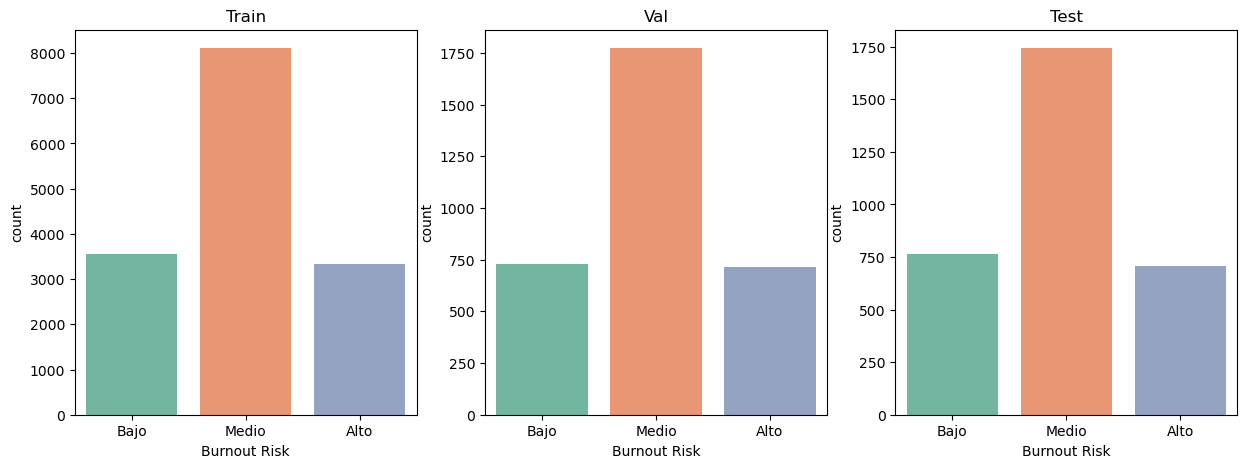

In [244]:
import seaborn as sns

# Grafica las distribuciones original y balanceadas (para compararlas)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x=df_train['Burnout Risk'], hue=df_train['Burnout Risk'], palette="Set2", ax=axes[0])
sns.countplot(x=df_val['Burnout Risk'], hue=df_val['Burnout Risk'], palette="Set2", ax=axes[1])
sns.countplot(x=df_test['Burnout Risk'], hue=df_test['Burnout Risk'], palette="Set2", ax=axes[2])

axes[0].set_title('Train')
axes[1].set_title('Val')
axes[2].set_title('Test')

plt.show()

Se observa que las clases están desbalanceadas, con una mayor cantidad de empleados en el rango medio. 

Por esta razón se evalúa la posible aplicación de dos métodos de balance de clases:
- **SMOTE**: para aumentar la cantidad de observaciones de las clases con menos observaciones.
- **RandomUnderSampler**: para reducir la cantidad de observaciones de la clase con más observaciones

In [245]:
# Separo el dataset en X (variables) y (target)
target = 'Burnout Risk'
X = df_train.drop(columns=[target])
y = df_train[target]

In [246]:
# Aplicación de SMOTE para balancear el dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res_sm, y_res_sm = smote.fit_resample(X, y)

In [247]:
# Aplicación de Random Under Sampling para balancear el dataset
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res_us, y_res_us = rus.fit_resample(X, y)

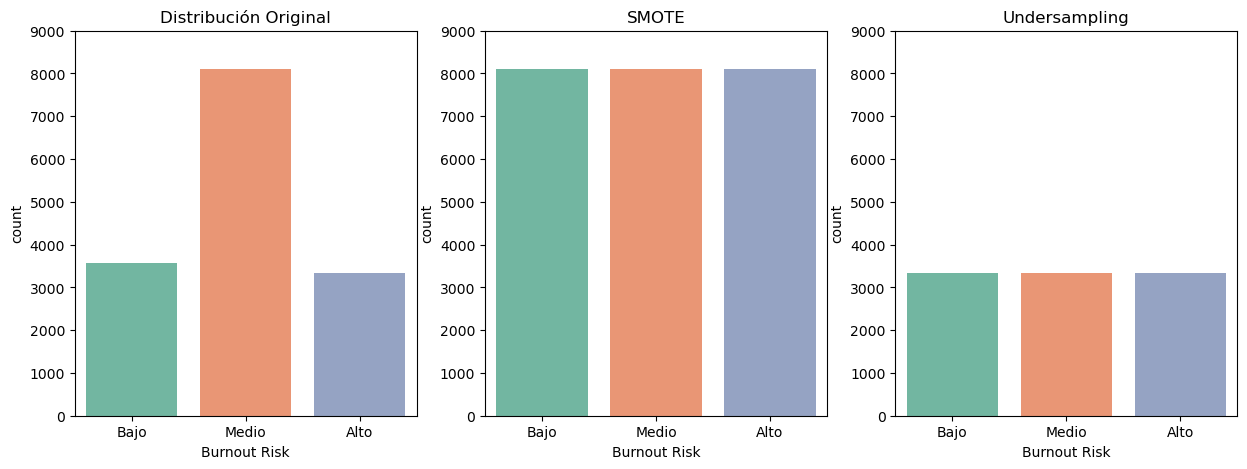

In [248]:
# Grafica las distribuciones original y balanceadas (para compararlas)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x=df_train['Burnout Risk'], hue=df_train['Burnout Risk'], palette="Set2", ax=axes[0])
sns.countplot(x=y_res_sm, hue=y_res_sm, palette="Set2", ax=axes[1])
sns.countplot(x=y_res_us, hue=y_res_us, palette="Set2", ax=axes[2])

axes[0].set_title('Distribución Original')
axes[1].set_title('SMOTE')
axes[2].set_title('Undersampling')

for i in (0,1,2):
  axes[i].set_ylim(0,9000)

plt.show()


**Conclusión:**

- SMOTE: preserva todos los datos originales y agrega nuevos ejemplos posibles. Esto puede ser útil para modelos sensibles al desbalance, como regresión logística o redes neuronales.

- Undersampling: también logra balance, pero a costa de eliminar observaciones de la clase mayoritaria. Sin embargo, puede llevar a pérdida de información y menor performance si la clase recortada era rica en variabilidad.

La elección del método va a depender del modelo a aplicar para el problema de clasificación y de las métricas obtenidas en cada caso.

Adicionalmente, para este caso se podría reevaluar la forma en la cual se separaron las clases inicialmente. Por ejemplo, se podría haber separado el dataset en 4 clases en lugar de 3.